# LoFi Bandit

In this notebook, we test LoFi bandit with TS v.s. LoFi bandit $\epsilon$-greedy v.s Neural $\epsilon$-greedy

In [136]:
import re
import os
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from loguru import logger

from bandits.agents.low_rank_filter_bandit import LowRankFilterBandit, LowRankGreedy
from bandits.agents.neural_greedy import NeuralGreedyBandit
from bandits.environments.mnist_env import MnistEnvironment

import lofi_tabular as experiment

In [15]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
ntrials = 1
npulls = 20
key = jax.random.PRNGKey(314)
key_env, key_train, key_eval = jax.random.split(key, 3)

# env = TabularEnvironment(key_env, ntrain=ntrain, name='statlog', intercept=False, path="../bandit-data")
env = MnistEnvironment(key, ntrain=500)
env_test = MnistEnvironment(key, ntrain=8_000) # 25_000

num_arms = env.labels_onehot.shape[-1]

In [27]:
class MLP(nn.Module):
    num_arms: int

    @nn.compact
    def __call__(self, x):
        # x = nn.Dense(200)(x)
        # x = nn.elu(x)
        # x = nn.Dense(200)(x)
        # x = nn.elu(x)
        x = nn.Dense(200, name="last_layer")(x)
        x = nn.elu(x)
        x = nn.Dense(self.num_arms)(x)
        return x
model = MLP(num_arms)

## Eval methods

In [74]:
logger.add("lofi-bandit-mnist.log")

1

In [75]:
list_memory = range(1, 31)
len(list_memory)

30

In [93]:
# %%time

results = {}
n_trials = 1 * 8
epsilon = 0.1

params = {
    "log_em_cov":  -10.0,
    "log_init_cov": -8.0,
}


extra_params_ts = {
    "model": model,
    "dynamics_weights": 1.0,
    "dynamics_covariance": 0.0,

}


extra_params_greedy = {
    **extra_params_ts,
    "epsilon": epsilon,
}


params_neural_greedy = {
    "log_lr": -8.0,
}

extra_params_neural_greedy = {
    "model": model,
    "epsilon": epsilon,
    "n_inner": 1.0,
}


for memory_size in list_memory:
    # ------------- Neural greedy -------------
    name_agent = f"neural-greedy-m{memory_size}"

    res = experiment.warmup_and_run(
        params_neural_greedy, 
        experiment.transform_hparams_rsgd,
        NeuralGreedyBandit,
        env_test,
        key_eval,
        npulls,
        n_trials=n_trials,
        memory_size=memory_size,
        **extra_params_neural_greedy
    )

    res = jax.tree_map(np.array, res)
    results[name_agent] = res
    
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()
    std_reward = rewards.sum(axis=1).std()
    
    info = f"{name_agent} - {mean_reward:0.2f}±{std_reward:0.2f}"
    logger.info(info)    
    
    
    
    # ------------- LoFi greedy -------------
    name = f"lofi-m{memory_size}"
    name_agent = f"{name}-greedy"
    res = experiment.warmup_and_run(
        params, 
        experiment.transform_hparams_lofi_fixed,
        LowRankGreedy,
        env_test,
        key_eval,
        npulls,
        n_trials=n_trials,
        **extra_params_greedy,
        memory_size=memory_size,
    )

    res = jax.tree_map(np.array, res)
    results[name_agent] = res
    
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()
    std_reward = rewards.sum(axis=1).std()
    
    info = f"{name_agent} - {mean_reward:0.2f}±{std_reward:0.2f}"
    logger.info(info)
    
    # ------------- LoFi Thompson Sampling -------------
    name_agent = f"{name}-ts"
    res = experiment.warmup_and_run(
        params, 
        experiment.transform_hparams_lofi_fixed,
        LowRankFilterBandit,
        env_test,
        key_eval,
        npulls,
        n_trials=n_trials,
        **extra_params_ts,
        memory_size=memory_size,
    )

    res = jax.tree_map(np.array, res)
    results[name_agent] = res
    
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()
    std_reward = rewards.sum(axis=1).std()
    
    info = f"{name_agent} - {mean_reward:0.2f}±{std_reward:0.2f}"
    logger.info(info)

2023-05-26 11:04:33.540 | INFO     | __main__:<module>:62 - neural-greedy-m1 - 147.50±22.39
2023-05-26 11:04:41.766 | INFO     | __main__:<module>:89 - lofi-m1-greedy - 5536.00±41.73
2023-05-26 11:04:55.705 | INFO     | __main__:<module>:113 - lofi-m1-ts - 6142.25±153.52
2023-05-26 11:04:57.898 | INFO     | __main__:<module>:62 - neural-greedy-m2 - 127.00±19.18
2023-05-26 11:05:06.814 | INFO     | __main__:<module>:89 - lofi-m2-greedy - 5560.88±52.26
2023-05-26 11:05:40.808 | INFO     | __main__:<module>:113 - lofi-m2-ts - 6000.00±268.07
2023-05-26 11:05:43.939 | INFO     | __main__:<module>:62 - neural-greedy-m3 - 127.38±20.14
2023-05-26 11:05:52.537 | INFO     | __main__:<module>:89 - lofi-m3-greedy - 5589.88±26.94
2023-05-26 11:06:26.289 | INFO     | __main__:<module>:113 - lofi-m3-ts - 6055.12±287.57
2023-05-26 11:06:28.519 | INFO     | __main__:<module>:62 - neural-greedy-m4 - 124.00±15.67
2023-05-26 11:06:37.364 | INFO     | __main__:<module>:89 - lofi-m4-greedy - 5588.12±48.62
2

In [155]:
final_rewards = {}
rewards_all = {}

for name, res in results.items():
    # label = name_mapping[name]
    memory = int(re.findall(r"[0-9]+", name)[0])
    label = f"{memory}"
    
    rewards = res["hist_train"]["rewards"]
    rewards_all[name] = rewards
    
    final_reward = res["hist_train"]["rewards"].sum(axis=1)
    final_rewards[name] = final_reward

regexp = re.compile(r"m([0-9]+)")
final_rewards = pd.DataFrame(final_rewards).melt(var_name="model", value_name="reward")
final_rewards["memory"] = final_rewards["model"].apply(lambda x: int(regexp.search(x)[1]))
final_rewards["model_type"] = final_rewards["model"].str.replace(r"-m[0-9]+", "", regex=True)

In [304]:
name_mapping = {
    "neural-greedy": r"RSGD $\epsilon$-greedy",
    "lofi-ts": "LOFI TS",
    "lofi-greedy": r"LOFI $\epsilon$-greedy",
}

In [305]:
final_rewards["name"] = final_rewards.model_type.apply(lambda x: name_mapping[x])

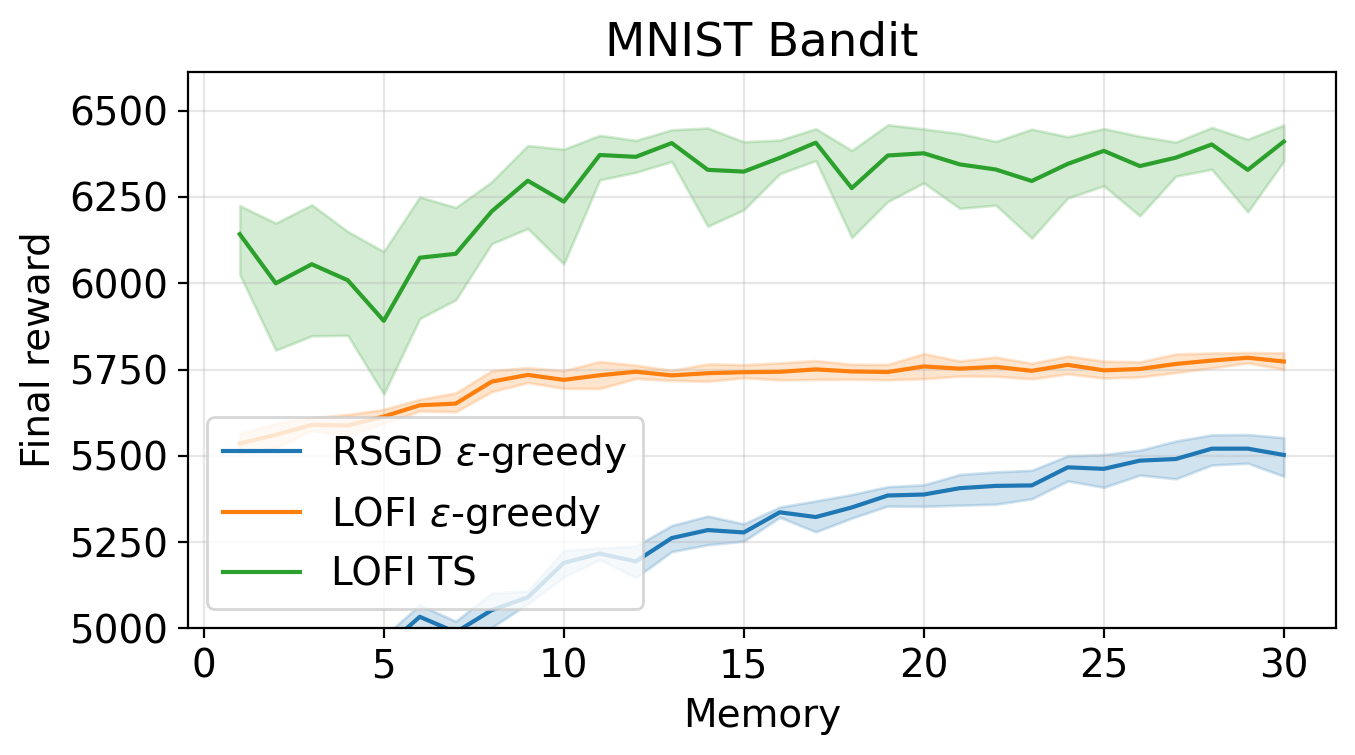

In [306]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(
    x="memory",
    y="reward",
    hue="name",
    data=final_rewards
)
plt.xlabel("Memory")
plt.ylabel("Final reward")
plt.grid(alpha=0.3)
plt.title("MNIST Bandit") # MNIST

ymin, ymax = plt.ylim()
plt.ylim(5000, ymax)
ax.legend(loc="lower left")
plt.tight_layout()
plt.savefig("./output/figures/mnist-bandits-lineplot.pdf")

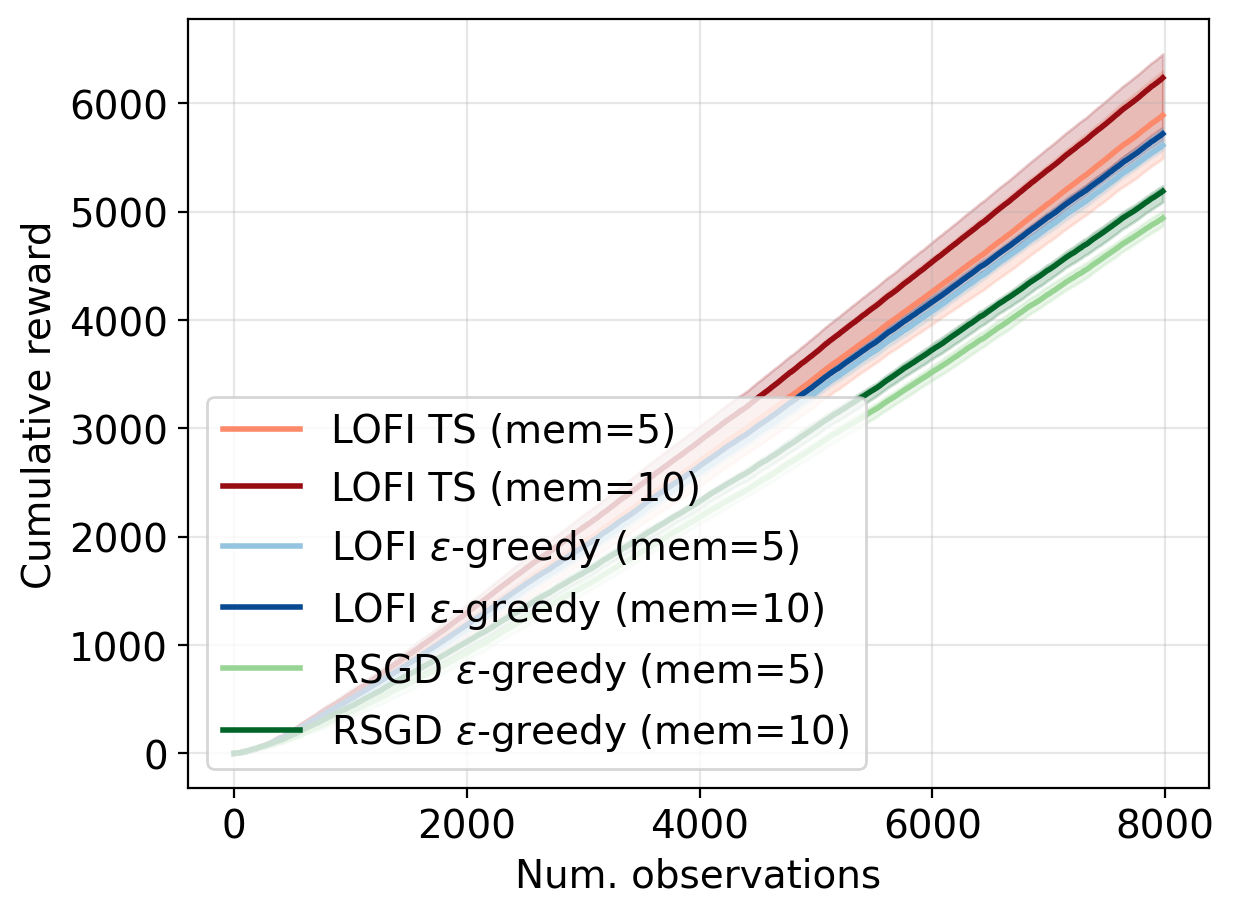

In [308]:
# fig, ax = plt.subplots(figsize=(7, 4))

def plot_reward_bound(rewards, color, name):
    rewards_cumsum = pd.DataFrame(rewards).cumsum(axis=0)

    rewards_mean = rewards_cumsum.mean(axis=1)
    rewards_lbound = rewards_cumsum.quantile(0.05, axis=1)
    rewards_ubound = rewards_cumsum.quantile(0.95, axis=1)

    rewards_mean.plot(label=name, color=color, linewidth=2)
    plt.fill_between(rewards_lbound.index, rewards_lbound, rewards_ubound, alpha=0.2, color=color)
    
mems = [5, 10]
colors_range = np.linspace(0.4, 0.9, 2)
for ix, mem in zip(colors_range, mems):
    name = f"lofi-m{mem}-ts"
    c = plt.cm.Reds(ix)
    
    rewards = rewards_all[name].T
    
    name = f"LOFI TS ({mem=})"
    plot_reward_bound(rewards, c, name)

    
colors_range = np.linspace(0.4, 0.9, 2)
for ix, mem in zip(colors_range, mems):
    c = plt.cm.Blues(ix)
    name = f"lofi-m{mem}-greedy"
    rewards = rewards_all[name].T
    name = f"LOFI $\epsilon$-greedy ({mem=})"
    plot_reward_bound(rewards, c, name)
    
    
names = ["neural-greedy-m5", "neural-greedy-m10"]
colors_range = np.linspace(0.4, 0.9, 2)
for ix, mem in zip(colors_range, mems):
    c = plt.cm.Greens(ix)
    name = f"neural-greedy-m{mem}"
    rewards = rewards_all[name].T
    name = f"RSGD $\epsilon$-greedy ({mem=})"
    plot_reward_bound(rewards, c, name)
    
plt.grid(alpha=0.3)
plt.legend(loc="lower left")
plt.ylabel("Cumulative reward")
plt.xlabel("Num. observations")
plt.tight_layout()
plt.savefig("./output/figures/mnist-bandits-v-time.pdf");

## $\epsilon$-greedy comparisson

* If $\epsilon=0$ then we always exploit
* If $\epsilon=1.0$ then we always explore (random)

In [ ]:
%%time

epsilon_values = np.linspace(0, 1, 30)
results_epsilon = {}
n_trials = 1 * 8


params = {
    "log_em_cov":  -10.0,
    "log_init_cov": -8.0,
}


extra_params_greedy = {
    "model": model,
    "dynamics_weights": 1.0,
    "dynamics_covariance": 0.0,
}


params_neural_greedy = {
    "log_lr": -8.0,
}

extra_params_neural_greedy = {
    "model": model,
    "n_inner": 1.0,
}


for memory_size in list_memory:
    for epsilon in epsilon_values:
        # ------------- Neural greedy -------------
        name_agent = f"neural-greedy-m{memory_size}-e{epsilon:0.3f}"

        res = experiment.warmup_and_run(
            params_neural_greedy, 
            experiment.transform_hparams_rsgd,
            NeuralGreedyBandit,
            env_test,
            key_eval,
            npulls,
            n_trials=n_trials,
            epsilon=epsilon,
            memory_size=memory_size,
            **extra_params_neural_greedy
        )

        res = jax.tree_map(np.array, res)
        results_epsilon[name_agent] = res

        rewards = res["hist_train"]["rewards"]
        mean_reward = rewards.sum(axis=1).mean()
        std_reward = rewards.sum(axis=1).std()

        info = f"{name_agent} - {mean_reward:0.2f}±{std_reward:0.2f}"
        logger.info(info)    



        # ------------- LoFi greedy -------------
        name = f"lofi-m{memory_size}-e{epsilon:0.3f}"
        name_agent = f"{name}-greedy"
        res = experiment.warmup_and_run(
            params, 
            experiment.transform_hparams_lofi_fixed,
            LowRankGreedy,
            env_test,
            key_eval,
            npulls,
            n_trials=n_trials,
            epsilon=epsilon,
            **extra_params_greedy,
            memory_size=memory_size,
        )

        res = jax.tree_map(np.array, res)
        results_epsilon[name_agent] = res

        rewards = res["hist_train"]["rewards"]
        mean_reward = rewards.sum(axis=1).mean()
        std_reward = rewards.sum(axis=1).std()

        info = f"{name_agent} - {mean_reward:0.2f}±{std_reward:0.2f}"
        logger.info(info)

2023-05-26 12:01:11.585 | INFO     | __main__:<module>:55 - neural-greedy-m1-e0.000 - 5701.00±0.00
2023-05-26 12:01:19.736 | INFO     | __main__:<module>:83 - lofi-m1-e0.000-greedy - 5987.00±0.00
2023-05-26 12:01:22.692 | INFO     | __main__:<module>:55 - neural-greedy-m1-e0.034 - 5707.12±75.36
2023-05-26 12:01:30.959 | INFO     | __main__:<module>:83 - lofi-m1-e0.034-greedy - 5906.00±56.30
2023-05-26 12:01:33.925 | INFO     | __main__:<module>:55 - neural-greedy-m1-e0.069 - 5501.50±64.07
2023-05-26 12:01:42.159 | INFO     | __main__:<module>:83 - lofi-m1-e0.069-greedy - 5723.88±50.52
2023-05-26 12:01:45.172 | INFO     | __main__:<module>:55 - neural-greedy-m1-e0.103 - 5305.12±35.77
2023-05-26 12:01:53.382 | INFO     | __main__:<module>:83 - lofi-m1-e0.103-greedy - 5512.62±54.55
2023-05-26 12:01:56.365 | INFO     | __main__:<module>:55 - neural-greedy-m1-e0.138 - 5071.00±54.36
2023-05-26 12:02:06.473 | INFO     | __main__:<module>:83 - lofi-m1-e0.138-greedy - 5303.00±38.04
2023-05-26 1